In [ ]:
import string
import numpy as np
import pandas as pd
from numpy import array
from PIL import Image
import pickle
import os
import matplotlib.pyplot as plt
import sys, time, os, warnings
warnings.filterwarnings("ignore")
import re
import matplotlib.image as mpimg
import glob
import keras
import tensorflow as tf
from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu

from keras.utils import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, BatchNormalization
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import add
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import load_img, img_to_array
from keras.preprocessing.text import Tokenizer

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
label_path_base =  "/content/drive/MyDrive/Colab Notebooks/onepiece"
df_onepiece_sorted = pd.read_csv(label_path_base + "/" + "df_onepiece_sorted.csv", encoding="euc-kr")

In [ ]:
new_columns = [
    'fid',
    'mood',
    'category',
    'fit',
    'length',
    'sleeve_length',
    'color',
    'material_1',
    'print_1'
]

df_onepiece = df_onepiece_sorted[new_columns]
df_onepice_dropna=df_onepiece.dropna(axis=0)

In [ ]:
df_onepice_dropna=df_onepice_dropna.drop(columns=['color'])

In [ ]:
df_onepice_dropna

,fid,mood,fit,length,sleeve_length,material_1,print_1
20,1185463,레트로,노멀,니렝스,7부소매,우븐,도트
21,68255,레트로,노멀,니렝스,7부소매,우븐,그래픽
22,68245,레트로,노멀,니렝스,7부소매,우븐,그래픽
23,11748,레트로,노멀,니렝스,긴팔,우븐,체크
24,958847,레트로,노멀,니렝스,긴팔,우븐,체크
...,...,...,...,...,...,...,...
21814,1074473,힙합,루즈,니렝스,긴팔,우븐,무지
21815,1159825,힙합,루즈,미니,긴팔,우븐,그래픽
21817,797796,힙합,오버사이즈,미디,긴팔,코듀로이,체크
21818,467920,힙합,오버사이즈,미디,긴팔,우븐,무지


In [ ]:
onepice=df_onepice_dropna['fid']
unique_words = list(onepice)
onepice_map = {}
for index, unique_word in enumerate(unique_words):
    onepice_map[unique_word] = list(df_onepice_dropna.iloc[index, 1:])

In [ ]:
image_paths=[]
for key, values in onepice_map.items():
    image_paths.append(key)

In [ ]:
jpgs = len(image_paths)

print("Total Images in Dataset = {}".format(jpgs))

Total Images in Dataset = 17562


In [ ]:
import copy

caption_descriptions={}

image_names = list(image_paths)
for i in range(0, len(image_paths)):
  image_name = image_names[i]
  caption_list = copy.deepcopy(onepice_map[image_name])
  caption_list.insert(0, 'startseq')  # 첫 번째 위치에 'start' 추가
  caption_list.append('endseq')  # 마지막 위치에 'end' 추가

  caption_descriptions[image_name] = caption_list

In [ ]:
def get_vocab():
    image_captions_map={}
    max_words=0
    unique_words=set()
    for key, values in caption_descriptions.items():
        max_words=max(max_words, len(values))
        [unique_words.add(caption_word) for caption_word in values]

    unique_words = list(unique_words)
    word_to_index_map = {}
    index_to_word_map = {}
    for index, unique_word in enumerate(unique_words):
        word_to_index_map[unique_word] = index
        index_to_word_map[index] = unique_word
    return max_words, unique_words, word_to_index_map, index_to_word_map

In [ ]:
max_words, unique_words, \
word_to_index_map, index_to_word_map = get_vocab()
vocabulary_size = len(unique_words)

In [ ]:
print('Vocabulary Size: %d' % vocabulary_size)

Vocabulary Size: 87


In [ ]:
def data_limiter(num,total_captions,all_img_name_vector):
   captions=[]
   img_name_vector = shuffle(all_img_name_vector,random_state=1)
   img_name_vector = img_name_vector[:num]
   image_names = list(img_name_vector)
   for i in range(0, len(image_names)):
      image_name = image_names[i]
      caption_list = copy.deepcopy(total_captions[image_name])
      captions.append(caption_list)
   return captions,img_name_vector

captions,img_name_vector = data_limiter(17536, caption_descriptions, image_paths)

In [ ]:
len(img_name_vector) #64배치*274

17536

In [ ]:
img_name=[]
work_dir='/content/drive/MyDrive/Colab Notebooks/onepiece/onepiece/*/'
for i in range(0, len(img_name_vector)):
      img = img_name_vector[i]
      path=glob.glob(work_dir+ str(img)+'.jpg')
      img_name.append(path[0])

In [ ]:
len(img_name)

17536

In [ ]:
def load_image(image_path):
   img = tf.io.read_file(image_path)
   img = tf.image.decode_jpeg(img, channels=3)
   img = tf.image.resize(img, (299, 299))
   img = tf.keras.applications.inception_v3.preprocess_input(img)
   return img, image_path

In [ ]:

#InceoptionV3으로 특징추출하기
image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

87910968/87910968 [==============================] - 1s 0us/step


In [ ]:
encode_train = sorted(set(img_name))
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(64)

In [ ]:
#안해도됨
for img, path in tqdm(image_dataset):
   batch_features = image_features_extract_model(img)
   batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))
   for bf, p in zip(batch_features, path):
      path_of_feature = p.numpy().decode("utf-8")
      np.save(path_of_feature, bf.numpy())

100%|██████████| 274/274 [05:21<00:00,  1.18s/it]


In [ ]:

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=vocabulary_size)

tokenizer.fit_on_texts(captions)
train_seqs = tokenizer.texts_to_sequences(captions)

cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [ ]:
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name, cap_vector, test_size=0.2, random_state=0)

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
num_steps = len(img_name_train) // BATCH_SIZE

def map_func(img_name, cap):
   img_tensor = np.load(img_name.decode('utf-8')+'.npy')
   return img_tensor, cap

dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))
dataset = dataset.map(lambda item1, item2: tf.numpy_function(map_func, [item1, item2], [tf.float32, tf.int32]),num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


In [ ]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return pos * angle_rates


def positional_encoding_1d(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)

    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)


def positional_encoding_2d(row, col, d_model):
    assert d_model % 2 == 0
    row_pos = np.repeat(np.arange(row), col)[:, np.newaxis]
    col_pos = np.repeat(np.expand_dims(np.arange(col), 0), row, axis=0).reshape(-1, 1)

    angle_rads_row = get_angles(row_pos, np.arange(d_model // 2)[np.newaxis, :], d_model // 2)
    angle_rads_col = get_angles(col_pos, np.arange(d_model // 2)[np.newaxis, :], d_model // 2)

    angle_rads_row[:, 0::2] = np.sin(angle_rads_row[:, 0::2])
    angle_rads_row[:, 1::2] = np.cos(angle_rads_row[:, 1::2])
    angle_rads_col[:, 0::2] = np.sin(angle_rads_col[:, 0::2])
    angle_rads_col[:, 1::2] = np.cos(angle_rads_col[:, 1::2])
    pos_encoding = np.concatenate([angle_rads_row, angle_rads_col], axis=1)[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

In [ ]:
def create_padding_mask(seq):
   seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
   return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

def create_look_ahead_mask(size):
   mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
   return mask  # (seq_len, seq_len)

def scaled_dot_product_attention(q, k, v, mask):
   matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
   dk = tf.cast(tf.shape(k)[-1], tf.float32)
   scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
   if mask is not None:
      scaled_attention_logits += (mask * -1e9)

   attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
   output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

   return output, attention_weights

class MultiHeadAttention_(tf.keras.layers.Layer):
   def __init__(self, d_model, num_heads):
      super(MultiHeadAttention_, self).__init__()
      self.num_heads = num_heads
      self.d_model = d_model
      assert d_model % self.num_heads == 0
      self.depth = d_model // self.num_heads
      self.wq = tf.keras.layers.Dense(d_model)
      self.wk = tf.keras.layers.Dense(d_model)
      self.wv = tf.keras.layers.Dense(d_model)
      self.dense = tf.keras.layers.Dense(d_model)

   def split_heads(self, x, batch_size):
      x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
      return tf.transpose(x, perm=[0, 2, 1, 3])

   def call(self, v, k, q, mask=None):
      batch_size = tf.shape(q)[0]
      q = self.wq(q)  # (batch_size, seq_len, d_model)
      k = self.wk(k)  # (batch_size, seq_len, d_model)
      v = self.wv(v)  # (batch_size, seq_len, d_model)

      q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
      k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
      v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

      scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
      scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q,      num_heads, depth)

      concat_attention = tf.reshape(scaled_attention,
                                 (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

      output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
      return output, attention_weights
def point_wise_feed_forward_network(d_model, dff):
   return tf.keras.Sequential([
                tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
                tf.keras.layers.Dense(d_model)])  # (batch_size, seq_len, d_model)

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
   def __init__(self, d_model, num_heads, dff, rate=0.1):
      super(EncoderLayer, self).__init__()
      self.mha = MultiHeadAttention_(d_model, num_heads)
      self.ffn = point_wise_feed_forward_network(d_model, dff)

      self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
      self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

      self.dropout1 = tf.keras.layers.Dropout(rate)
      self.dropout2 = tf.keras.layers.Dropout(rate)


   def call(self, x, training, mask=None):
      attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
      attn_output = self.dropout1(attn_output, training=training)
      out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

      ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
      ffn_output = self.dropout2(ffn_output, training=training)
      out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
      return out2
class DecoderLayer(tf.keras.layers.Layer):
   def __init__(self, d_model, num_heads, dff, rate=0.1):
      super(DecoderLayer, self).__init__()
      self.mha1 = MultiHeadAttention_(d_model, num_heads)
      self.mha2 = MultiHeadAttention_(d_model, num_heads)

      self.ffn = point_wise_feed_forward_network(d_model, dff)

      self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
      self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
      self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

      self.dropout1 = tf.keras.layers.Dropout(rate)
      self.dropout2 = tf.keras.layers.Dropout(rate)
      self.dropout3 = tf.keras.layers.Dropout(rate)

   def call(self, x, enc_output, training,look_ahead_mask=None, padding_mask=None):
      attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
      attn1 = self.dropout1(attn1, training=training)
      out1 = self.layernorm1(attn1 + x)

      attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)
      attn2 = self.dropout2(attn2, training=training)
      out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

      ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
      ffn_output = self.dropout3(ffn_output, training=training)
      out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

      return out3, attn_weights_block1, attn_weights_block2

In [ ]:
class Encoder(tf.keras.layers.Layer):
   def __init__(self, num_layers, d_model, num_heads, dff, row_size,col_size,rate=0.1):
      super(Encoder, self).__init__()
      self.d_model = d_model
      self.num_layers = num_layers

      self.embedding = tf.keras.layers.Dense(self.d_model,activation='relu')
      self.pos_encoding = positional_encoding_2d(row_size,col_size,self.d_model)

      self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
      self.dropout = tf.keras.layers.Dropout(rate)

   def call(self, x, training, mask=None):
      seq_len = tf.shape(x)[1]
      x = self.embedding(x)  # (batch_size, input_seq_len(H*W), d_model)
      x += self.pos_encoding[:, :seq_len, :]
      x = self.dropout(x, training=training)

      for i in range(self.num_layers):
         x = self.enc_layers[i](x, training, mask)

      return x  # (batch_size, input_seq_len, d_model)
class Decoder(tf.keras.layers.Layer):
   def __init__(self, num_layers,d_model,num_heads,dff, target_vocab_size, maximum_position_encoding,   rate=0.1):
      super(Decoder, self).__init__()
      self.d_model = d_model
      self.num_layers = num_layers

      self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
      self.pos_encoding = positional_encoding_1d(maximum_position_encoding, d_model)

      self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate)
                         for _ in range(num_layers)]
      self.dropout = tf.keras.layers.Dropout(rate)

   def call(self, x, enc_output, training,look_ahead_mask=None, padding_mask=None):
      seq_len = tf.shape(x)[1]
      attention_weights = {}

      x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
      x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
      x += self.pos_encoding[:, :seq_len, :]
      x = self.dropout(x, training=training)

      for i in range(self.num_layers):
         x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                            look_ahead_mask, padding_mask)

         attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
         attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

      return x, attention_weights

In [ ]:
class Transformer(tf.keras.Model):
   def __init__(self, num_layers, d_model, num_heads, dff,row_size,col_size,
              target_vocab_size,max_pos_encoding, rate=0.1):
      super(Transformer, self).__init__()
      self.encoder = Encoder(num_layers, d_model, num_heads, dff,row_size,col_size, rate)
      self.decoder = Decoder(num_layers, d_model, num_heads, dff,
                          target_vocab_size,max_pos_encoding, rate)
      self.final_layer = tf.keras.layers.Dense(target_vocab_size)

   def call(self, inp, tar, training,look_ahead_mask=None,dec_padding_mask=None,enc_padding_mask=None   ):
      enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model      )
      dec_output, attention_weights = self.decoder(
      tar, enc_output, training, look_ahead_mask, dec_padding_mask)
      final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
      return final_output, attention_weights

In [ ]:
num_layer = 4
d_model = 512
dff = 2048
num_heads = 8
row_size = 8
col_size = 8
target_vocab_size = vocabulary_size
dropout_rate = 0.1
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
   def __init__(self, d_model, warmup_steps=4000):
      super(CustomSchedule, self).__init__()
      self.d_model = d_model
      self.d_model = tf.cast(self.d_model, tf.float32)
      self.warmup_steps = warmup_steps

   def __call__(self, step):
      step = tf.cast(step, dtype=tf.float32)
      arg1 = tf.math.rsqrt(step)
      arg2 = step * (self.warmup_steps ** -1.5)

      return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
   mask = tf.math.logical_not(tf.math.equal(real, 0))
   loss_ = loss_object(real, pred)
   mask = tf.cast(mask, dtype=loss_.dtype)
   loss_ *= mask
   return tf.reduce_sum(loss_)/tf.reduce_sum(mask)
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
transformer = Transformer(num_layer,d_model,num_heads,dff,row_size,col_size,target_vocab_size,max_pos_encoding=target_vocab_size,rate=dropout_rate)

In [ ]:
def create_masks_decoder(tar):
   look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
   dec_target_padding_mask = create_padding_mask(tar)
   combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
   return combined_mask
@tf.function
def train_step(img_tensor, tar):
   tar_inp = tar[:, :-1]
   tar_real = tar[:, 1:]
   dec_mask = create_masks_decoder(tar_inp)
   with tf.GradientTape() as tape:
      predictions, _ = transformer(img_tensor, tar_inp,True, dec_mask)
      loss = loss_function(tar_real, predictions)

   gradients = tape.gradient(loss, transformer.trainable_variables)
   optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
   train_loss(loss)
   train_accuracy(tar_real, predictions)

In [ ]:
#안해도됨
a=0
loss=[]
accuracy=[]
for epoch in range(30):
   start = time.time()
   train_loss.reset_states()
   train_accuracy.reset_states()
   for (batch, (img_tensor, tar)) in enumerate(dataset):
      train_step(img_tensor, tar)
      loss.append(train_loss.result())
      accuracy.append(train_accuracy.result())
      if batch % 50 == 0:
         print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
         epoch + 1, batch, train_loss.result(), train_accuracy.result()))

   print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1,
                                               train_loss.result(),
                                               train_accuracy.result()))
   if train_accuracy.result()>a:
      transformer.save_weights('image_caption_transformer_30.h5')
      a=train_accuracy.result()
      print("모델새로업데이트")

   print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

In [ ]:
first_element = dataset.take(1)
for img_tensor, tar in first_element:
  train_step(img_tensor, tar)
transformer.load_weights('/content/drive/MyDrive/Colab Notebooks/onepiece/image_caption_transformer_30.h5')

In [ ]:
def evaluate(image):
    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
    start_token = tokenizer.word_index['startseq']
    end_token = tokenizer.word_index['endseq']
    decoder_input = [start_token]
    output = tf.expand_dims(decoder_input, 0)  # tokens
    result = []  # word list

    for i in range(100):
        dec_mask = create_masks_decoder(output)
        predictions, attention_weights = transformer(img_tensor_val, output, False, dec_mask)
        predictions = predictions[:, -1:, :]  # (batch_size, 1, vocab_size)
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
        if predicted_id == end_token:
            return result, tf.squeeze(output, axis=0), attention_weights
        result.append(tokenizer.index_word[int(predicted_id)])
        output = tf.concat([output, predicted_id], axis=-1)

    return result, tf.squeeze(output, axis=0), attention_weights

In [ ]:

import os

path_dir = '/content/drive/MyDrive/Colab Notebooks/onepiece/A22'
all_file=[]
file_list = os.listdir(path_dir)
all_file.extend(file_list)
path_dir = '/content/drive/MyDrive/Colab Notebooks/onepiece/A21'
file_list = os.listdir(path_dir)
all_file.extend(file_list)
path_dir = '/content/drive/MyDrive/Colab Notebooks/onepiece/A20'
file_list = os.listdir(path_dir)
all_file.extend(file_list)

In [ ]:
len(all_file)

918

In [ ]:
img_name=[]
work_dir='/content/drive/MyDrive/Colab Notebooks/onepiece/*/'
for i in range(0, len(all_file)):
      img = all_file[i]
      path=glob.glob(work_dir+ str(img))
      img_name.append(path[0])

Prediction Caption: 로맨틱 드레스 루즈 미디 반팔 시폰 플로럴


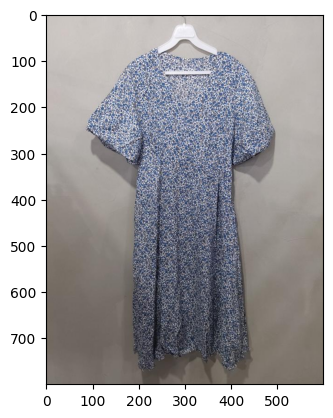

In [ ]:
# captions on the validation set
rid = np.random.randint(0, len(img_name))
image = img_name[rid]
result, _, attention_plot = evaluate(image)

print('Prediction Caption:', ' '.join(result))
#plot_attention(image, result, attention_plot)
plt.imshow(Image.open(image))
plt.show()

Prediction Caption: 리조트 드레스 루즈 미디 반팔 우븐 그래픽


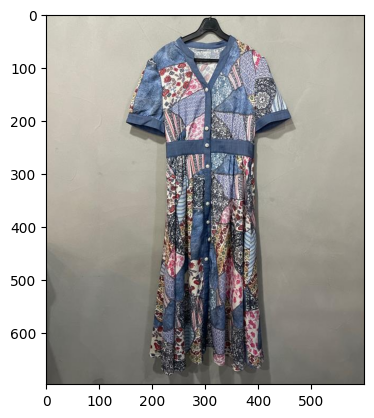

In [ ]:
# captions on the validation set
rid = np.random.randint(0, len(img_name))
image = img_name[rid]
result, _, attention_plot = evaluate(image)

print('Prediction Caption:', ' '.join(result))
#plot_attention(image, result, attention_plot)
plt.imshow(Image.open(image))
plt.show()

Prediction Caption: 스트리트 드레스 루즈 미디 민소매 데님 무지


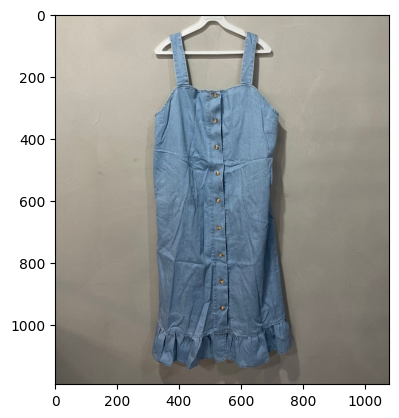

In [ ]:
# captions on the validation set
rid = np.random.randint(0, len(img_name))
image = img_name[rid]
result, _, attention_plot = evaluate(image)

print('Prediction Caption:', ' '.join(result))
#plot_attention(image, result, attention_plot)
plt.imshow(Image.open(image))
plt.show()

Prediction Caption: 스트리트 드레스 루즈 미디 긴팔 우븐 무지


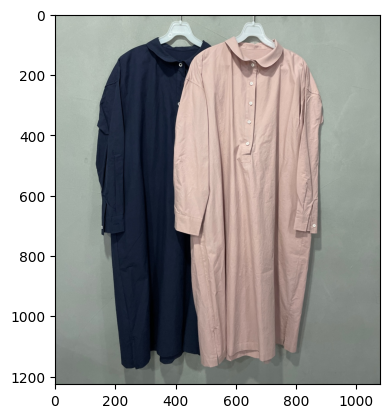

In [ ]:
# captions on the validation set
rid = np.random.randint(0, len(img_name))
image = img_name[rid]
result, _, attention_plot = evaluate(image)

print('Prediction Caption:', ' '.join(result))
#plot_attention(image, result, attention_plot)
plt.imshow(Image.open(image))
plt.show()

Prediction Caption: 오리엔탈 드레스 루즈 니렝스 반팔 우븐 그래픽


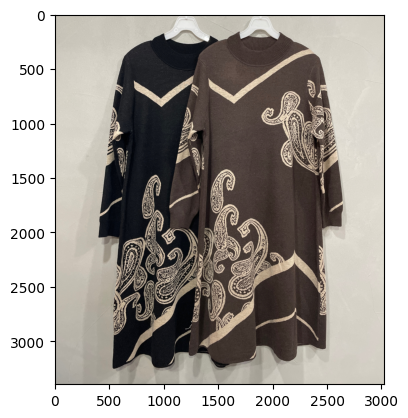

In [ ]:
# captions on the validation set
rid = np.random.randint(0, len(img_name))
image = img_name[rid]
result, _, attention_plot = evaluate(image)

print('Prediction Caption:', ' '.join(result))
#plot_attention(image, result, attention_plot)
plt.imshow(Image.open(image))
plt.show()

Prediction Caption: 페미닌 드레스 노멀 미디 반팔 우븐 도트


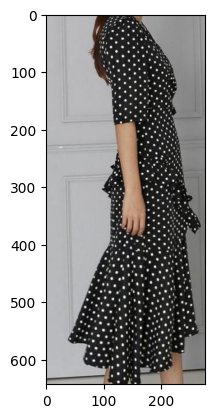

In [ ]:
# captions on the validation set
rid = np.random.randint(0, len(img_name))
image = img_name[rid]
result, _, attention_plot = evaluate(image)

print('Prediction Caption:', ' '.join(result))
#plot_attention(image, result, attention_plot)
plt.imshow(Image.open(image))
plt.show()

Prediction Caption: 히피 드레스 노멀 미디 반팔 시폰 페이즐리


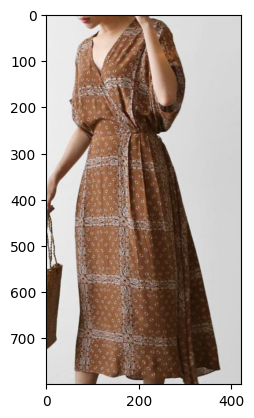

In [ ]:
# captions on the validation set
rid = np.random.randint(0, len(img_name))
image = img_name[rid]
result, _, attention_plot = evaluate(image)

print('Prediction Caption:', ' '.join(result))
#plot_attention(image, result, attention_plot)
plt.imshow(Image.open(image))
plt.show()

Prediction Caption: 스트리트 드레스 루즈 니렝스 반팔 저지 스트라이프


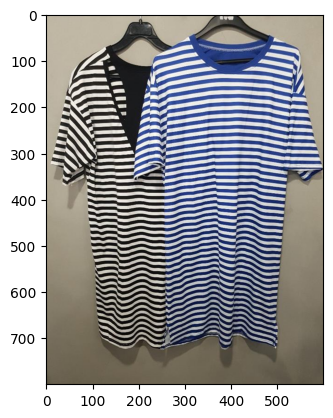

In [ ]:
# captions on the validation set
rid = np.random.randint(0, len(img_name))
image = img_name[rid]
result, _, attention_plot = evaluate(image)

print('Prediction Caption:', ' '.join(result))
#plot_attention(image, result, attention_plot)
plt.imshow(Image.open(image))
plt.show()

In [ ]:
# captions on the validation set
nineoz_map={}
for rid in range(len(all_file)):
    image = img_name[rid]
    result, _, attention_plot = evaluate(image)
    print('Prediction Caption:', ' '.join(result))
    unique_word=all_file[rid]
    nineoz_map[unique_word] = list(result)


Prediction Caption: 모던 드레스 루즈 미디 7부소매 우븐 무지
Prediction Caption: 스트리트 드레스 루즈 미디 긴팔 우븐 무지
Prediction Caption: 스트리트 드레스 루즈 미디 반팔 우븐 무지
Prediction Caption: 페미닌 드레스 루즈 미디 반팔 시폰 플로럴
Prediction Caption: 모던 드레스 루즈 미디 7부소매 우븐 무지
Prediction Caption: 로맨틱 드레스 노멀 미디 긴팔 시폰 플로럴
Prediction Caption: 페미닌 드레스 노멀 미디 반팔 시폰 플로럴
Prediction Caption: 스트리트 드레스 루즈 미디 반팔 우븐 무지
Prediction Caption: 리조트 드레스 루즈 미디 반팔 우븐 무지
Prediction Caption: 로맨틱 드레스 노멀 미디 반팔 우븐 플로럴
Prediction Caption: 히피 드레스 루즈 니렝스 반팔 우븐 그래픽
Prediction Caption: 스트리트 드레스 루즈 니렝스 긴팔 저지 레터링
Prediction Caption: 로맨틱 드레스 루즈 미디 반팔 우븐 플로럴
Prediction Caption: 리조트 드레스 루즈 미디 반팔 우븐 무지
Prediction Caption: 리조트 드레스 루즈 미디 반팔 우븐 무지
Prediction Caption: 리조트 드레스 루즈 발목 긴팔 우븐 무지
Prediction Caption: 리조트 드레스 루즈 미디 반팔 우븐 무지
Prediction Caption: 모던 드레스 루즈 니렝스 반팔 우븐 그래픽
Prediction Caption: 리조트 드레스 루즈 발목 반팔 우븐 무지
Prediction Caption: 스트리트 드레스 루즈 미디 긴팔 데님 무지
Prediction Caption: 페미닌 드레스 루즈 발목 7부소매 우븐 그래픽
Prediction Caption: 오리엔탈 드레스 루즈 니렝스 반팔 시폰 그래픽
Prediction Caption: 모던 드레스 루즈 니렝

In [ ]:
with open('nineoz.pkl', 'wb') as f:
  pickle.dump(nineoz_map, f)

In [ ]:
with open('nineoz.pkl', 'rb') as f:
  mydict=pickle.load(f)

In [ ]:
mydict

{'AJB3OP001.jpg': ['모던', '드레스', '루즈', '미디', '7부소매', '우븐', '무지'],
 'AJB3OP005.jpg': ['스트리트', '드레스', '루즈', '미디', '긴팔', '우븐', '무지'],
 'AJC3OP023.jpg': ['스트리트', '드레스', '루즈', '미디', '반팔', '우븐', '무지'],
 'AJC3OP018.jpg': ['페미닌', '드레스', '루즈', '미디', '반팔', '시폰', '플로럴'],
 'AJC3OP011.jpg': ['모던', '드레스', '루즈', '미디', '7부소매', '우븐', '무지'],
 'AJC3OP015.jpg': ['로맨틱', '드레스', '노멀', '미디', '긴팔', '시폰', '플로럴'],
 'AJC7OP004.jpg': ['페미닌', '드레스', '노멀', '미디', '반팔', '시폰', '플로럴'],
 'AJB7OP001.jpg': ['스트리트', '드레스', '루즈', '미디', '반팔', '우븐', '무지'],
 'AJG3OP038.jpg': ['리조트', '드레스', '루즈', '미디', '반팔', '우븐', '무지'],
 'AJG3OP029.jpg': ['로맨틱', '드레스', '노멀', '미디', '반팔', '우븐', '플로럴'],
 'AJG3OP003.jpg': ['히피', '드레스', '루즈', '니렝스', '반팔', '우븐', '그래픽'],
 'AJG3OP024.jpg': ['스트리트', '드레스', '루즈', '니렝스', '긴팔', '저지', '레터링'],
 'AJG3OP031.jpg': ['로맨틱', '드레스', '루즈', '미디', '반팔', '우븐', '플로럴'],
 'AJG3OP016.jpg': ['리조트', '드레스', '루즈', '미디', '반팔', '우븐', '무지'],
 'AJF3OP013.jpg': ['리조트', '드레스', '루즈', '미디', '반팔', '우븐', '무지'],
 'AJF3OP002.jpg': ['리조트', 

In [ ]:
# captions on the validation set
image = img_name_val[rid]
result, _, attention_plot = evaluate(image)

print('Prediction Caption:', ' '.join(result))


Prediction Caption: 스트리트 드레스 루즈 미디 긴팔 그린 저지 레터링


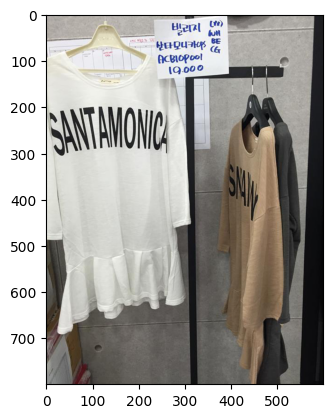

In [ ]:
image='/content/ACB1OP0011.jpg'
result, _, attention_plot = evaluate(image)

#print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
#plot_attention(image, result, attention_plot)
plt.imshow(Image.open(image))
plt.show()

In [ ]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = 8
    for i in range(len_result):
        temp_att = np.resize(list(attention_plot.values())[i], (8, 8))
        grid_size = int(max(np.ceil(len_result/2), 2))
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()

Real Caption: startseq 페미닌 드레스 루즈 니렝스 반팔 우븐 무지 endseq
Prediction Caption: 페미닌 드레스 노멀 니렝스 반팔 우븐 체크


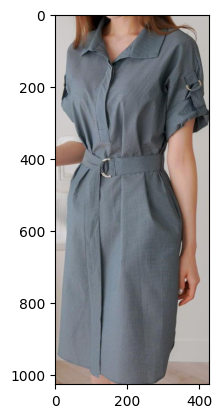

In [ ]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i]
                        for i in cap_val[rid] if i not in [0]])
result, _, attention_plot = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
#plot_attention(image, result, attention_plot)
plt.imshow(Image.open(image))
plt.show()

Real Caption: startseq 페미닌 드레스 노멀 미디 긴팔 우븐 무지 endseq
Prediction Caption: 리조트 드레스 루즈 미디 긴팔 데님 무지


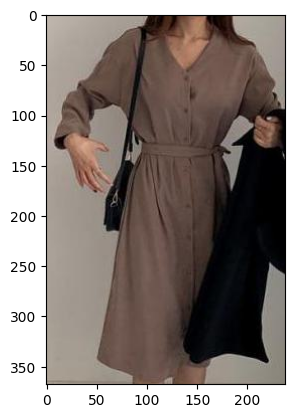

In [ ]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i]
                        for i in cap_val[rid] if i not in [0]])
result, _, attention_plot = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
#plot_attention(image, result, attention_plot)
plt.imshow(Image.open(image))
plt.show()

Real Caption: startseq 모던 드레스 루즈 미디 반팔 우븐 무지 endseq
Prediction Caption: 리조트 드레스 루즈 미디 반팔 린넨 무지


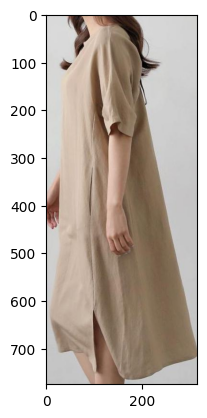

In [ ]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i]
                        for i in cap_val[rid] if i not in [0]])
result, _, attention_plot = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
#plot_attention(image, result, attention_plot)
plt.imshow(Image.open(image))
plt.show()

Real Caption: startseq 페미닌 드레스 노멀 미니 긴팔 우븐 체크 endseq
Prediction Caption: 스트리트 드레스 루즈 니렝스 긴팔 우븐 체크


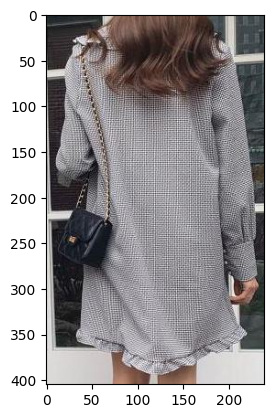

In [ ]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i]
                        for i in cap_val[rid] if i not in [0]])
result, _, attention_plot = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
#plot_attention(image, result, attention_plot)
plt.imshow(Image.open(image))
plt.show()

Real Caption: startseq 페미닌 드레스 노멀 발목 반팔 우븐 무지 endseq
Prediction Caption: 리조트 드레스 루즈 미디 반팔 우븐 무지


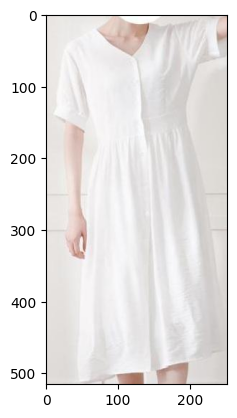

In [ ]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i]
                        for i in cap_val[rid] if i not in [0]])
result, _, attention_plot = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
#plot_attention(image, result, attention_plot)
plt.imshow(Image.open(image))
plt.show()

Real Caption: startseq 오리엔탈 드레스 노멀 미디 7부소매 우븐 플로럴 endseq
Prediction Caption: 로맨틱 드레스 노멀 미디 반팔 시폰 플로럴


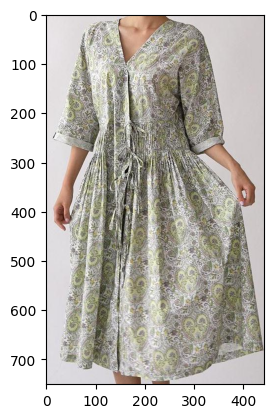

In [ ]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i]
                        for i in cap_val[rid] if i not in [0]])
result, _, attention_plot = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
#plot_attention(image, result, attention_plot)
plt.imshow(Image.open(image))
plt.show()

Real Caption: startseq 스트리트 드레스 노멀 미니 반팔 우븐 무지 endseq
Prediction Caption: 모던 드레스 노멀 니렝스 반팔 우븐 무지


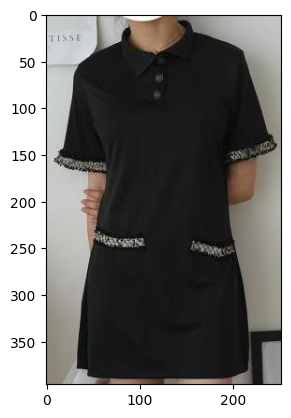

In [ ]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i]
                        for i in cap_val[rid] if i not in [0]])
result, _, attention_plot = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
#plot_attention(image, result, attention_plot)
plt.imshow(Image.open(image))
plt.show()

Real Caption: startseq 로맨틱 드레스 노멀 니렝스 반팔 우븐 플로럴 endseq
Prediction Caption: 로맨틱 드레스 노멀 니렝스 반팔 시폰 플로럴


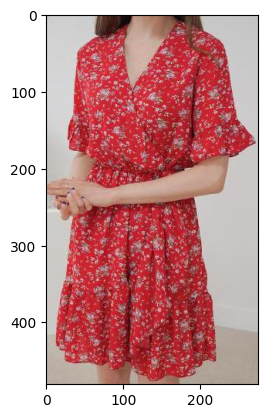

In [ ]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i]
                        for i in cap_val[rid] if i not in [0]])
result, _, attention_plot = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
#plot_attention(image, result, attention_plot)
plt.imshow(Image.open(image))
plt.show()

Real Caption: startseq 리조트 드레스 루즈 미디 반팔 저지 레터링 endseq
Prediction Caption: 스트리트 드레스 루즈 니렝스 반팔 저지 레터링


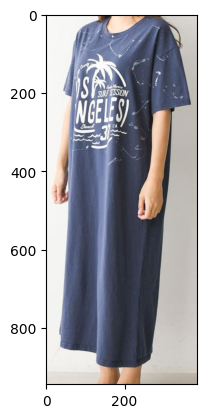

In [ ]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i]
                        for i in cap_val[rid] if i not in [0]])
result, _, attention_plot = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
#plot_attention(image, result, attention_plot)
plt.imshow(Image.open(image))
plt.show()

In [ ]:
bleu1=[]
bleu2=[]
bleu3=[]
bleu4=[]
for i in range(len(img_name_val)):
  image = img_name_val[i]
  real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[i] if i not in [0]])
  caption,result,attention_weights = evaluate(image)
  first = real_caption.split(' ', 1)[1]
  real_caption = first.rsplit(' ', 1)[0]
  result_join = ' '.join(caption)
  result_final = result_join.rsplit(' ', 1)[0]
  real_appn = []
  real_appn.append(real_caption.split())
  reference = real_appn
  candidate = caption

  score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
  bleu1.append(score)
  score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
  bleu2.append(score)
  score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
  bleu3.append(score)
  score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
  bleu4.append(score)

In [ ]:
def calculate_mean(numbers):
    return sum(numbers) / len(numbers)



# 리스트의 평균 계산
print(calculate_mean(bleu1))
print(calculate_mean(bleu2))
print(calculate_mean(bleu3))
print(calculate_mean(bleu4))

0.6560571534082517
0.5087359107674323
0.37452152221292595
0.22064991643607673


BLEU-1 score: 85.71428571428571
BLEU-2 score: 75.59289460184544
BLEU-3 score: 72.53271942569272
BLEU-4 score: 64.34588841607616
Real Caption: 로맨틱 드레스 노멀 니렝스 긴팔 우븐 플로럴
Predicted Caption: 로맨틱 드레스 노멀 니렝스 긴팔 시폰 플로럴


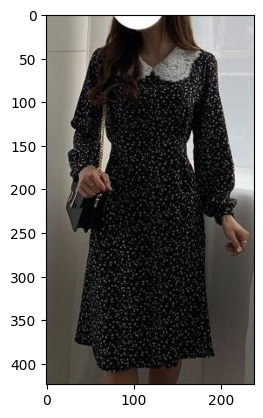

In [ ]:
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
caption,result,attention_weights = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]



result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]
real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = caption

score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
print(f"BLEU-1 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
print(f"BLEU-2 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
print(f"BLEU-3 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
print(f"BLEU-4 score: {score*100}")
print ('Real Caption:', real_caption)
print ('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(image))
plt.imshow(temp_image)

BLEU-1 score: 62.5
BLEU-2 score: 51.75491695067657
BLEU-3 score: 39.34826562662495
BLEU-4 score: 5.614021910443866e-76
Real Caption: 리조트 드레스 루즈 니렝스 반팔 실버 저지 무지
Predicted Caption: 스트리트 드레스 루즈 발목 긴팔 실버 저지 무지


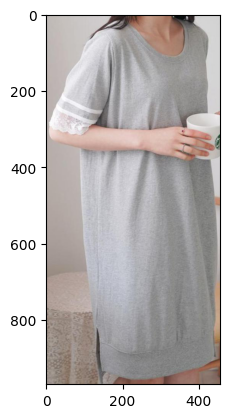

In [ ]:
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
caption,result,attention_weights = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]



result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]
real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = caption

score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
print(f"BLEU-1 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
print(f"BLEU-2 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
print(f"BLEU-3 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
print(f"BLEU-4 score: {score*100}")
print ('Real Caption:', real_caption)
print ('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(image))
plt.imshow(temp_image)